In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import numpy as np
import matplotlib.dates as mdates


In [3]:
# Load the data from the csv file, and parse the dates to datetime format
df_TAT = pd.read_excel("Vorlage_TAT_Lithium.xlsx", header=[0, 1])

# Ab der dritten Spalte die Werte in datetime konvertieren
for col in df_TAT.columns[2:]:  # Nur ab der dritten Spalte
    df_TAT[col] = pd.to_datetime(df_TAT[col], errors='coerce', dayfirst=True)  # Fehlerhafte Werte werden zu NaT


df_TAT.head()
df_TAT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   (Unnamed: 0_level_0, Auftragsnummer)        316 non-null    int64         
 1   (Unnamed: 1_level_0, Anforderung)           316 non-null    object        
 2   (Präanalytische Phase, Eingang)             316 non-null    datetime64[ns]
 3   (Analytische Phase, Messung)                316 non-null    datetime64[ns]
 4   (Postanalytische Phase, Tech. Validation)   316 non-null    datetime64[ns]
 5   (Postanalytische Phase, Validation)         316 non-null    datetime64[ns]
 6   (Postanalytische Phase, Auftragsabschluss)  316 non-null    datetime64[ns]
dtypes: datetime64[ns](5), int64(1), object(1)
memory usage: 17.4+ KB


In [4]:
df_TAT.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Präanalytische Phase  \
      Auftragsnummer        Anforderung              Eingang   
0           21553310                 li  2024-05-15 12:45:45   
1           21554328                 li  2024-05-16 13:01:01   
2           21547858                 li  2024-05-06 12:38:54   
3           40615708                 li  2024-05-31 12:18:47   
4           40596835                 li  2024-05-14 12:26:35   

    Analytische Phase Postanalytische Phase                      \
              Messung      Tech. Validation          Validation   
0 2024-05-15 14:46:59   2024-05-15 16:10:00 2024-05-15 17:07:01   
1 2024-05-16 14:15:22   2024-05-16 14:56:01 2024-05-16 16:00:00   
2 2024-05-06 14:13:00   2024-05-06 15:01:00 2024-05-06 15:45:00   
3 2024-05-31 13:06:10   2024-05-31 13:10:00 2024-05-31 13:41:00   
4 2024-05-14 13:17:32   2024-05-14 13:47:00 2024-05-14 13:58:00   

                       
    Auftragsabschluss  
0 2024-05-15 17:07:01  
1 2024-05-16 16:00:00  
2 2024-05-06 15:45:00  
3 2024-05-31 14:25:36  
4 2024-05-14 13:58:00

In [5]:
# Dictionary zur Speicherung der Phasen und ihrer Schritte
phases = {}

# Iteration über die Spalten ab der dritten
for col in df_TAT.columns[2:]:
    phase = col[0].strip()  # Übergeordnete Phase
    step = col[1].strip()   # Untergeordneter Schritt
    
    # Phase hinzufügen, falls noch nicht vorhanden
    if phase not in phases:
        phases[phase] = []
    
    # Schritt hinzufügen, falls noch nicht vorhanden
    if step not in phases[phase]:
        phases[phase].append(step)

# Ausgabe der Phasenstruktur
for phase, checkpoints in phases.items():
    print(f"{phase}:")
    for checkpoint in checkpoints:
        print(f"  - {checkpoint}")

Präanalytische Phase:
  - Eingang
Analytische Phase:
  - Messung
Postanalytische Phase:
  - Tech. Validation
  - Validation
  - Auftragsabschluss


In [6]:
# Nur die zweite Hierarchieebene behalten
df_TAT.columns = df_TAT.columns.droplevel(0)

In [7]:
# Get the keys of the phases
phase_keys = list(phases.keys())

# Iterate through the phases
for i in range(len(phase_keys)):
    current_phase = phase_keys[i]
    current_phase_checkpoints = phases[current_phase]

    last_phase = len(phase_keys) - 1 # With 3 phases, the last phase is 2

    if i < last_phase:
        # For all but the last phase, calculate the difference between the first column of the current phase and the next phase
        next_phase = phase_keys[i + 1]
        next_phase_checkpoints = phases[next_phase]

        coL_phase_start = current_phase_checkpoints[0]
        col_phase_end = next_phase_checkpoints[0]

        print(f"Calculating TAT for {current_phase}: {coL_phase_start} - {col_phase_end}")

        df_TAT[f"{current_phase}"] = df_TAT[col_phase_end] - df_TAT[coL_phase_start]

        df_TAT[f"{current_phase} in Minuten"] = df_TAT[current_phase].dt.total_seconds() / 60

    else:
        # For the last phase, calculate the difference between its first and last column

        coL_phase_start = current_phase_checkpoints[0]
        col_phase_end = current_phase_checkpoints[-1]
        
        print(f"Calculating TAT for {current_phase}: {coL_phase_start} - {col_phase_end}")

        df_TAT[f"{current_phase}"] = df_TAT[col_phase_end] - df_TAT[coL_phase_start]

        df_TAT[f"{current_phase} in Minuten"] = df_TAT[current_phase].dt.total_seconds() / 60

df_TAT


Calculating TAT for Präanalytische Phase: Eingang - Messung
Calculating TAT for Analytische Phase: Messung - Tech. Validation
Calculating TAT for Postanalytische Phase: Tech. Validation - Auftragsabschluss


,Auftragsnummer,Anforderung,Eingang,Messung,Tech. Validation,Validation,Auftragsabschluss,Präanalytische Phase,Präanalytische Phase in Minuten,Analytische Phase,Analytische Phase in Minuten,Postanalytische Phase,Postanalytische Phase in Minuten
0,21553310,li,2024-05-15 12:45:45,2024-05-15 14:46:59,2024-05-15 16:10:00,2024-05-15 17:07:01,2024-05-15 17:07:01,0 days 02:01:14,121.233333,0 days 01:23:01,83.016667,0 days 00:57:01,57.016667
1,21554328,li,2024-05-16 13:01:01,2024-05-16 14:15:22,2024-05-16 14:56:01,2024-05-16 16:00:00,2024-05-16 16:00:00,0 days 01:14:21,74.350000,0 days 00:40:39,40.650000,0 days 01:03:59,63.983333
2,21547858,li,2024-05-06 12:38:54,2024-05-06 14:13:00,2024-05-06 15:01:00,2024-05-06 15:45:00,2024-05-06 15:45:00,0 days 01:34:06,94.100000,0 days 00:48:00,48.000000,0 days 00:44:00,44.000000
3,40615708,li,2024-05-31 12:18:47,2024-05-31 13:06:10,2024-05-31 13:10:00,2024-05-31 13:41:00,2024-05-31 14:25:36,0 days 00:47:23,47.383333,0 days 00:03:50,3.833333,0 days 01:15:36,75.600000
4,40596835,li,2024-05-14 12:26:35,2024-05-14 13:17:32,2024-05-14 13:47:00,2024-05-14 13:58:00,2024-05-14 13:58:00,0 days 00:50:57,50.950000,0 days 00:29:28,29.466667,0 days 00:11:00,11.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,55021815,li,2024-05-01 13:54:13,2024-05-01 14:38:02,2024-05-01 15:05:00,2024-05-01 16:03:00,2024-05-01 16:03:00,0 days 00:43:49,43.816667,0 days 00:26:58,26.966667,0 days 00:58:00,58.000000
312,21545187,li,2024-05-01 12:34:29,2024-05-01 13:33:43,2024-05-01 13:40:00,2024-05-01 13:50:01,2024-05-01 13:50:01,0 days 00:59:14,59.233333,0 days 00:06:17,6.283333,0 days 00:10:01,10.016667
313,21544962,li,2024-05-01 14:23:43,2024-05-01 16:53:26,2024-05-01 16:56:00,2024-05-01 17:05:01,2024-05-09 02:07:55,0 days 02:29:43,149.716667,0 days 00:02:34,2.566667,7 days 09:11:55,10631.916667
314,21544237,li,2024-05-01 18:19:59,2024-05-01 19:04:56,2024-05-01 19:19:00,2024-05-01 19:27:00,2024-05-01 19:27:00,0 days 00:44:57,44.950000,0 days 00:14:04,14.066667,0 days 00:08:00,8.000000


In [8]:
# Calculate the difference between the first and last checkpoint over all phases
first_checkpoint = phases[phase_keys[0]][0]
last_checkpoint = phases[phase_keys[-1]][-1]

df_TAT['Total_TAT'] = df_TAT[last_checkpoint] - df_TAT[first_checkpoint]
df_TAT['Total_TAT in Minuten'] = df_TAT['Total_TAT'].dt.total_seconds() / 60
df_TAT[['Total_TAT', 'Total_TAT in Minuten']]

,Total_TAT,Total_TAT in Minuten
0,0 days 04:21:16,261.266667
1,0 days 02:58:59,178.983333
2,0 days 03:06:06,186.100000
3,0 days 02:06:49,126.816667
4,0 days 01:31:25,91.416667
...,...,...
311,0 days 02:08:47,128.783333
312,0 days 01:15:32,75.533333
313,7 days 11:44:12,10784.200000
314,0 days 01:07:01,67.016667


In [9]:
df_TAT.describe()

,Auftragsnummer,Eingang,Messung,Tech. Validation,Validation,Auftragsabschluss,Präanalytische Phase,Präanalytische Phase in Minuten,Analytische Phase,Analytische Phase in Minuten,Postanalytische Phase,Postanalytische Phase in Minuten,Total_TAT,Total_TAT in Minuten
count,3.160000e+02,316,316,316,316,316,316,316.000000,316,316.000000,316,316.000000,316,316.000000
mean,3.586426e+07,2024-05-16 23:50:38.632911360,2024-05-17 02:02:19.018987264,2024-05-17 02:27:48.579113728,2024-05-17 03:06:43.582278400,2024-05-17 17:34:02.468354304,0 days 02:11:40.386075949,131.673101,0 days 00:25:29.560126582,25.492669,0 days 15:06:13.889240506,906.231487,0 days 17:43:23.835443037,1063.397257
min,1.182992e+07,2024-05-01 12:34:12,2024-05-01 13:18:55,2024-05-01 13:40:00,2024-05-01 13:50:01,2024-05-01 13:50:01,0 days 00:20:44,20.733333,0 days 00:00:27,0.450000,0 days 00:01:00,1.000000,0 days 00:32:12,32.200000
25%,2.155461e+07,2024-05-08 13:43:50.750000128,2024-05-08 17:36:05.500000,2024-05-08 17:40:03,2024-05-08 17:55:05.500000,2024-05-09 00:16:15,0 days 00:54:11.750000,54.195833,0 days 00:06:52.750000,6.879167,0 days 00:11:01.750000,11.029167,0 days 01:48:40.250000,108.670833
50%,4.054283e+07,2024-05-16 12:51:31.500000,2024-05-16 13:57:01,2024-05-16 14:37:01.500000,2024-05-16 15:57:30,2024-05-16 23:44:43.500000,0 days 01:14:54.500000,74.908333,0 days 00:17:59,17.983333,0 days 00:39:00,39.000000,0 days 03:15:47.500000,195.791667
75%,4.061257e+07,2024-05-24 12:31:16,2024-05-24 13:36:22,2024-05-24 13:47:12.500000,2024-05-24 13:58:15.750000128,2024-05-24 15:15:15.249999872,0 days 02:04:57.250000,124.954167,0 days 00:33:42.250000,33.704167,0 days 10:41:45.250000,641.754167,0 days 13:34:24.250000,814.404167
max,5.503217e+07,2024-06-03 10:14:28,2024-06-03 12:49:59,2024-06-03 12:56:00,2024-06-03 13:42:00,2024-06-10 16:58:00,2 days 18:20:10,3980.166667,0 days 02:13:45,133.750000,15 days 23:29:51,23009.850000,16 days 03:43:40,23263.666667
std,1.343133e+07,NaN,NaN,NaN,NaN,NaN,0 days 04:22:16.367635058,262.272794,0 days 00:24:45.525825196,24.758764,1 days 18:26:48.663152417,2546.811053,1 days 18:38:21.654092317,2558.360902


# Diagramme

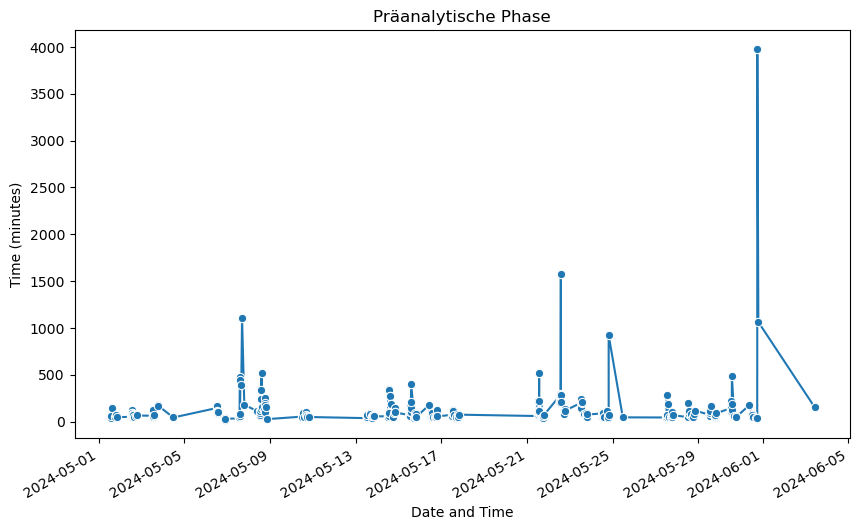

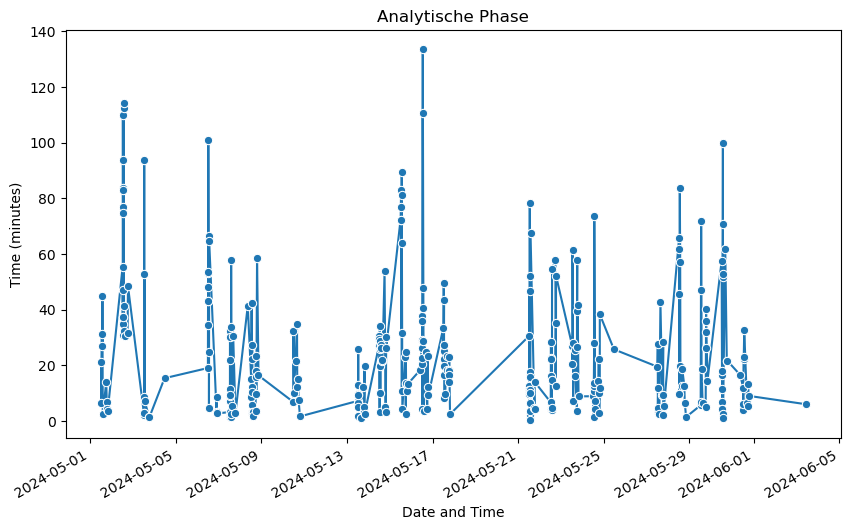

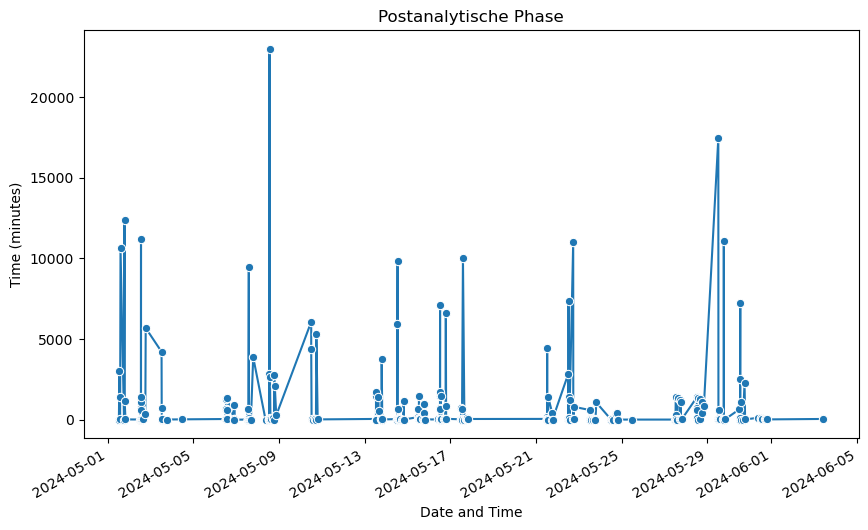

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

def plot_phase(df, phase_column, time_column='Eingang', time_format='%Y-%m-%d', title='Phase Plot'):
    """
    Dynamisches Plotten von Daten für jede Phase.
    
    Parameters:
        df (pd.DataFrame): DataFrame mit den Daten
        phase_column (str): Die Spalte, die die Phase repräsentiert (z. B. 'Präanalytische Phase in Minuten')
        time_column (str): Die Spalte, die das Datum/Zeit enthält (Standard: 'Eingang')
        time_format (str): Format für das Datum auf der x-Achse (Standard: '%Y-%m-%d')
        title (str): Titel des Diagramms
    """
    # Liniendiagramm erstellen
    fig = plt.figure(figsize=(10, 6))
    sns.lineplot(x=df[time_column], y=df[phase_column], marker='o')

    # Achsenanpassungen
    ax = plt.gca()

    # Datumsformat auf der x-Achse anpassen
    ax.xaxis.set_major_formatter(mdates.DateFormatter(time_format))

    # Wissenschaftliche Notation auf der y-Achse deaktivieren
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.get_offset_text().set_visible(False)  # Optional: Offset-Text entfernen

    # Datumswerte auf der x-Achse schön formatieren
    fig.autofmt_xdate()

    # Titel und Achsenbeschriftungen hinzufügen
    plt.title(title)
    plt.xlabel('Date and Time')
    plt.ylabel('Time (minutes)')

    # Diagramm anzeigen
    plt.show()

# Dynamisch durch das Dictionary gehen und Diagramme erstellen
for phase, steps in phases.items():
        # Name der Spalte mit Phase und Schritt
        phase_column = f"{phase} in Minuten"
        # Diagramm für jede Phase generieren
        plot_phase(df_TAT, phase_column, time_column=df_TAT.columns[2], time_format='%Y-%m-%d', title=phase)

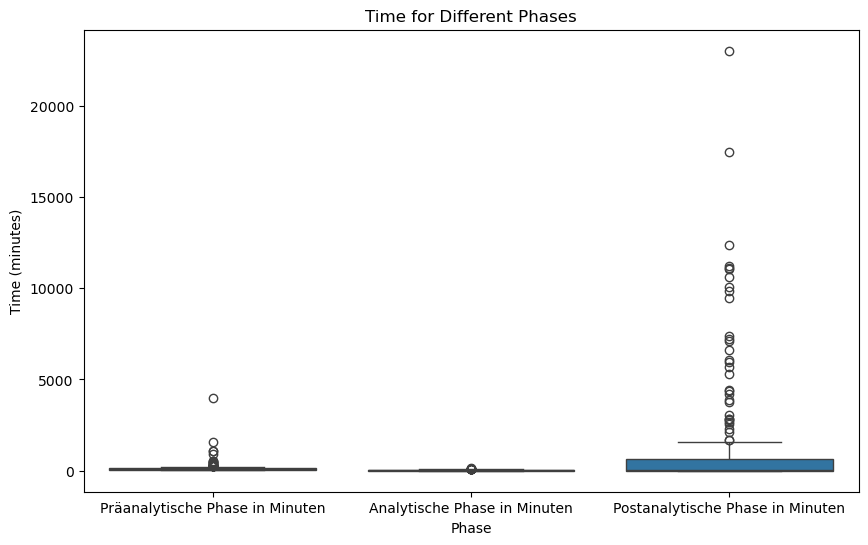

In [11]:
# Dynamisch die Zeitspalten basierend auf den Phasen-Schlüsseln auswählen
time_columns = [f"{phase} in Minuten" for phase in phases.keys()]

# Melt the DataFrame to long format for seaborn
df_melted = df_TAT.melt(id_vars=[df_TAT.columns[2]], value_vars=time_columns, var_name='Phase', value_name='Time (minutes)')

# Create a box and whiskers plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Phase', y='Time (minutes)', data=df_melted)
plt.title('Time for Different Phases')
plt.ylabel('Time (minutes)')
plt.xlabel('Phase')
plt.show()

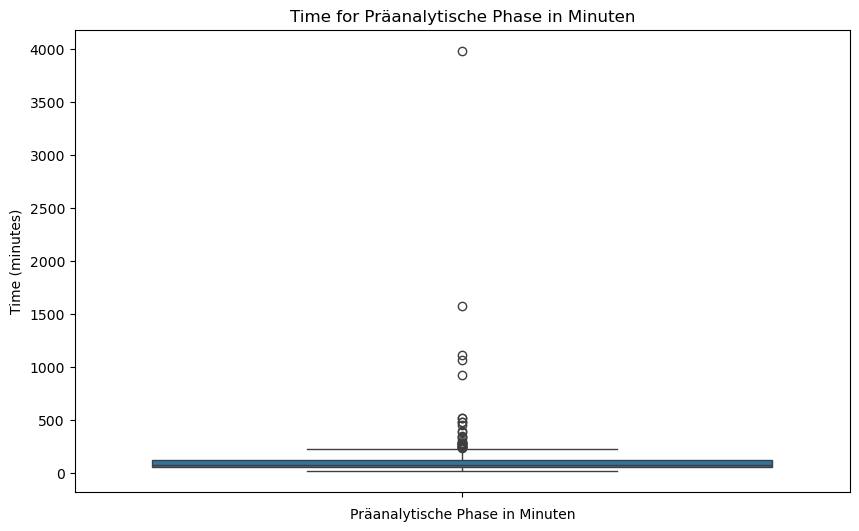

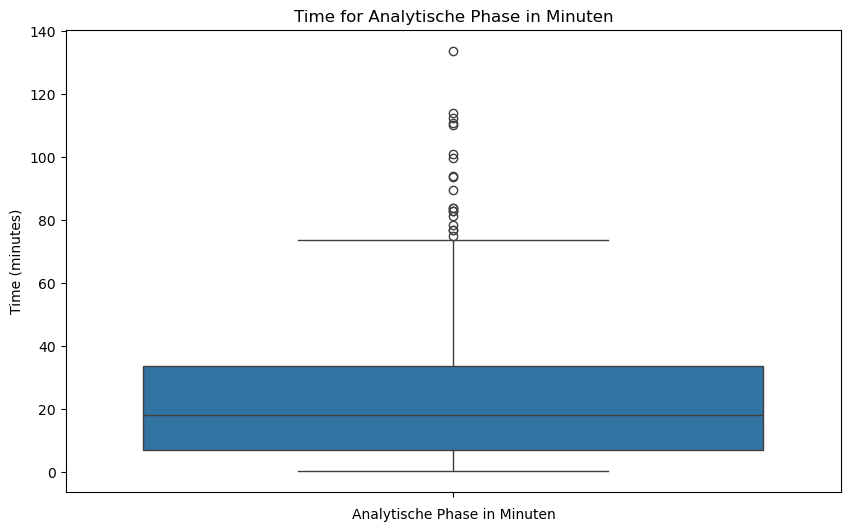

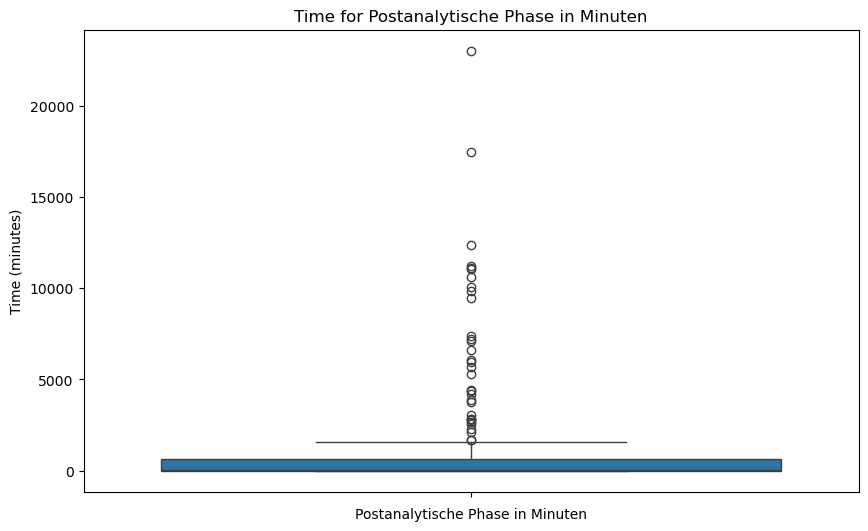

In [12]:
# Create separate box and whiskers plots for each phase
phases = df_melted['Phase'].unique()
for phase in phases:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y='Time (minutes)', data=df_melted[df_melted['Phase'] == phase])
    plt.title(f'Time for {phase}')
    plt.ylabel('Time (minutes)')
    plt.xlabel(phase)
    plt.show()

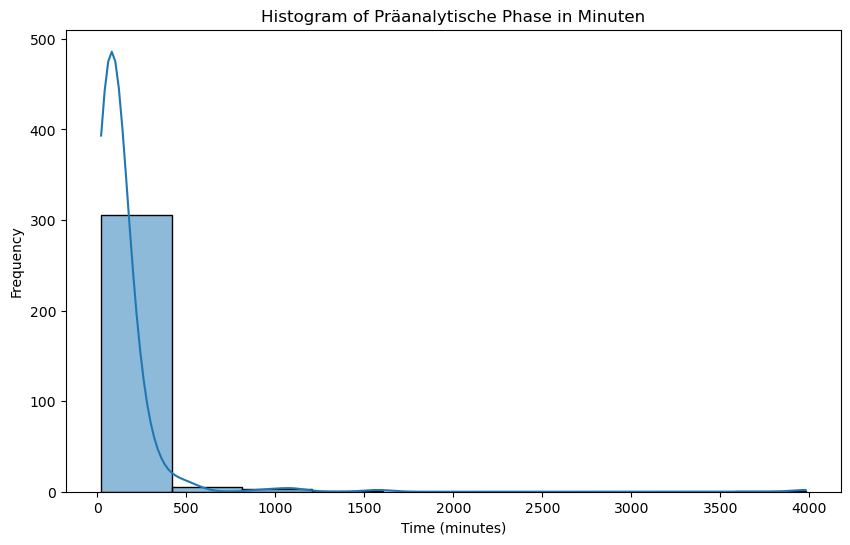

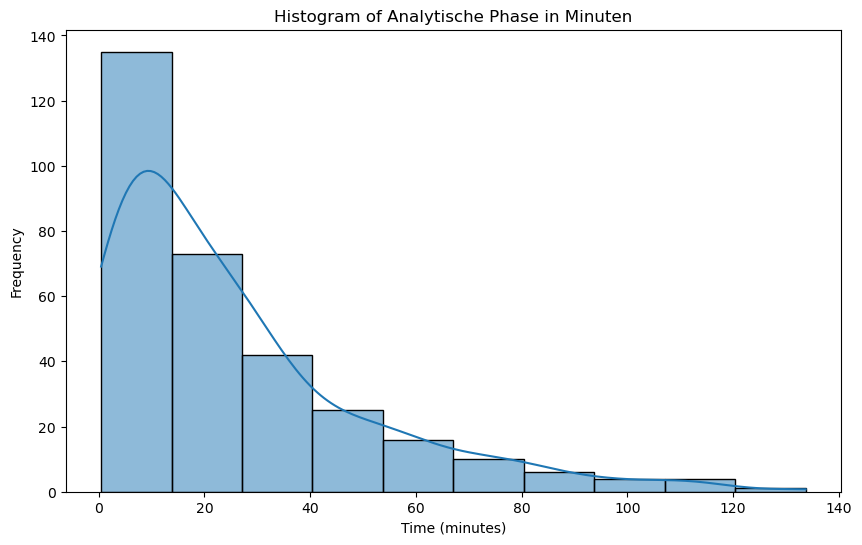

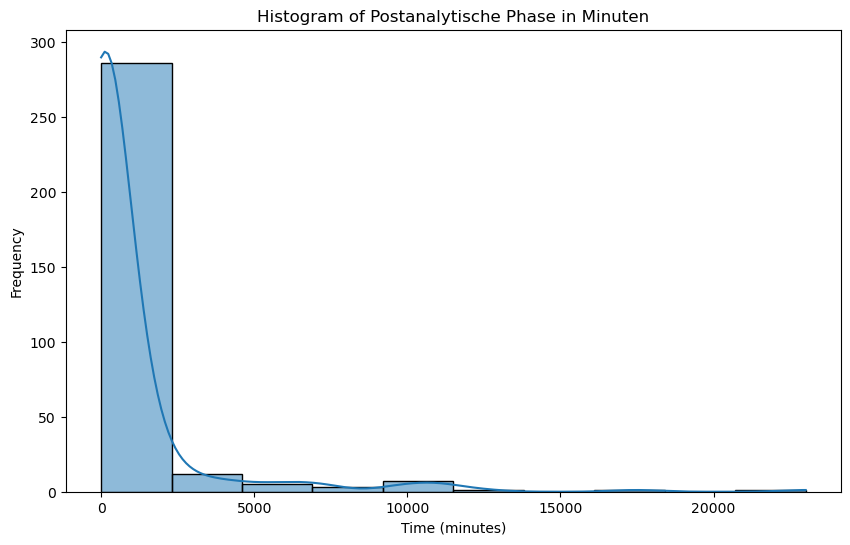

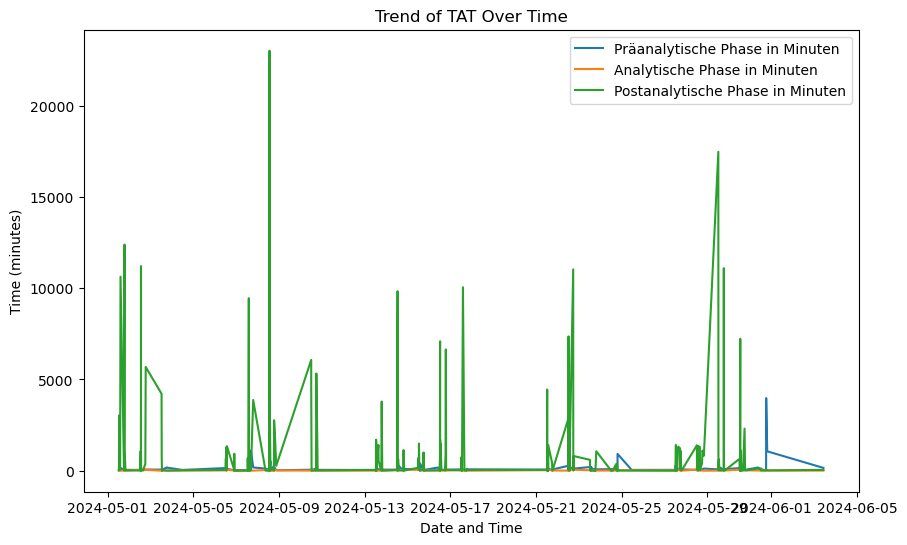

In [13]:
# Histogram for each phase
for phase in time_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_TAT[phase], bins=10, kde=True)
    plt.title(f'Histogram of {phase}')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Frequency')
    plt.show()

# Line plot to show the trend of TAT over time
plt.figure(figsize=(10, 6))
for phase in time_columns:
    sns.lineplot(x=df_TAT['Eingang'], y=df_TAT[phase], label=phase)
plt.title('Trend of TAT Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Time (minutes)')
plt.legend()
plt.show()

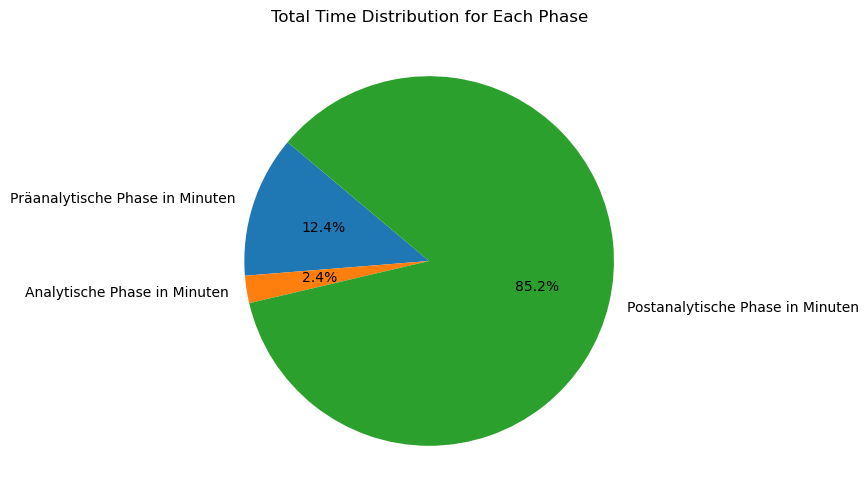

In [14]:
# Sum the total time for each phase
phase_sums = df_TAT[time_columns].sum()

# Create a pie chart
plt.figure(figsize=(10, 6))
plt.pie(phase_sums, labels=phase_sums.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Time Distribution for Each Phase')
plt.show()

# Diagramme ohne Outliers

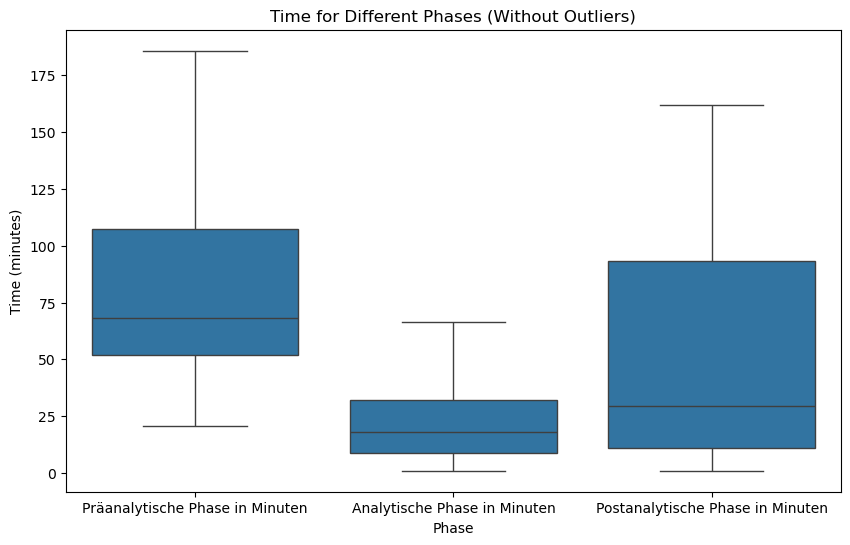

In [15]:
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each phase
df_cleaned = df_TAT.copy()
for phase in time_columns:
    df_cleaned = remove_outliers(df_cleaned, phase)


# Melt the cleaned DataFrame to long format for seaborn
df_melted_cleaned = df_cleaned.melt(id_vars=[df_TAT.columns[2]], value_vars=time_columns, var_name='Phase', value_name='Time (minutes)')

# Create a box and whiskers plot without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Phase', y='Time (minutes)', data=df_melted_cleaned, showfliers=False)
plt.title('Time for Different Phases (Without Outliers)')
plt.ylabel('Time (minutes)')
plt.xlabel('Phase')
plt.show()

In [16]:
display(df_cleaned)

,Auftragsnummer,Anforderung,Eingang,Messung,Tech. Validation,Validation,Auftragsabschluss,Präanalytische Phase,Präanalytische Phase in Minuten,Analytische Phase,Analytische Phase in Minuten,Postanalytische Phase,Postanalytische Phase in Minuten,Total_TAT,Total_TAT in Minuten
1,21554328,li,2024-05-16 13:01:01,2024-05-16 14:15:22,2024-05-16 14:56:01,2024-05-16 16:00:00,2024-05-16 16:00:00,0 days 01:14:21,74.350000,0 days 00:40:39,40.650000,0 days 01:03:59,63.983333,0 days 02:58:59,178.983333
2,21547858,li,2024-05-06 12:38:54,2024-05-06 14:13:00,2024-05-06 15:01:00,2024-05-06 15:45:00,2024-05-06 15:45:00,0 days 01:34:06,94.100000,0 days 00:48:00,48.000000,0 days 00:44:00,44.000000,0 days 03:06:06,186.100000
3,40615708,li,2024-05-31 12:18:47,2024-05-31 13:06:10,2024-05-31 13:10:00,2024-05-31 13:41:00,2024-05-31 14:25:36,0 days 00:47:23,47.383333,0 days 00:03:50,3.833333,0 days 01:15:36,75.600000,0 days 02:06:49,126.816667
4,40596835,li,2024-05-14 12:26:35,2024-05-14 13:17:32,2024-05-14 13:47:00,2024-05-14 13:58:00,2024-05-14 13:58:00,0 days 00:50:57,50.950000,0 days 00:29:28,29.466667,0 days 00:11:00,11.000000,0 days 01:31:25,91.416667
5,21562463,li,2024-05-30 18:27:29,2024-05-30 19:17:23,2024-05-30 19:39:00,2024-05-30 19:52:01,2024-05-30 19:52:01,0 days 00:49:54,49.900000,0 days 00:21:37,21.616667,0 days 00:13:01,13.016667,0 days 01:24:32,84.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,55021350,li,2024-05-01 12:34:12,2024-05-01 13:18:55,2024-05-01 13:40:00,2024-05-01 13:50:01,2024-05-01 13:50:01,0 days 00:44:43,44.716667,0 days 00:21:05,21.083333,0 days 00:10:01,10.016667,0 days 01:15:49,75.816667
311,55021815,li,2024-05-01 13:54:13,2024-05-01 14:38:02,2024-05-01 15:05:00,2024-05-01 16:03:00,2024-05-01 16:03:00,0 days 00:43:49,43.816667,0 days 00:26:58,26.966667,0 days 00:58:00,58.000000,0 days 02:08:47,128.783333
312,21545187,li,2024-05-01 12:34:29,2024-05-01 13:33:43,2024-05-01 13:40:00,2024-05-01 13:50:01,2024-05-01 13:50:01,0 days 00:59:14,59.233333,0 days 00:06:17,6.283333,0 days 00:10:01,10.016667,0 days 01:15:32,75.533333
314,21544237,li,2024-05-01 18:19:59,2024-05-01 19:04:56,2024-05-01 19:19:00,2024-05-01 19:27:00,2024-05-01 19:27:00,0 days 00:44:57,44.950000,0 days 00:14:04,14.066667,0 days 00:08:00,8.000000,0 days 01:07:01,67.016667


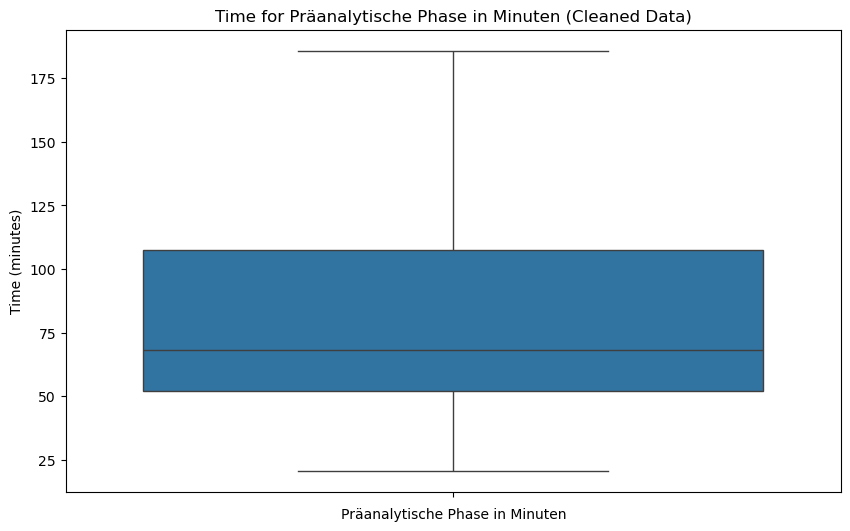

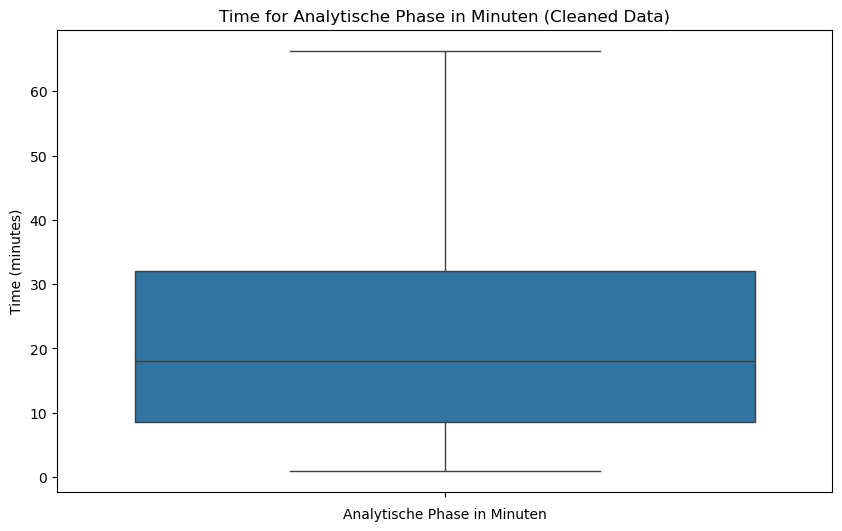

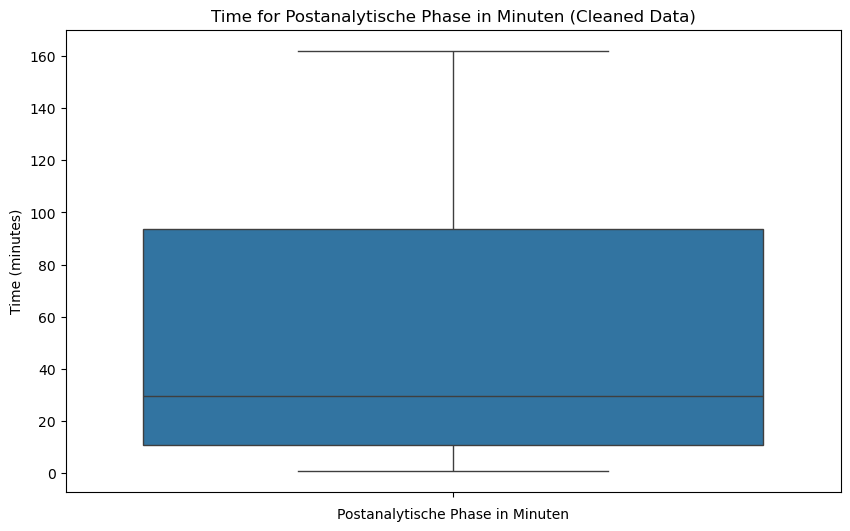

In [17]:
# Create separate box and whiskers plots for each phase using the cleaned DataFrame
phases_cleaned = df_melted_cleaned['Phase'].unique()
for phase in phases_cleaned:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y='Time (minutes)', data=df_melted_cleaned[df_melted_cleaned['Phase'] == phase],showfliers=False)
    plt.title(f'Time for {phase} (Cleaned Data)')
    plt.ylabel('Time (minutes)')
    plt.xlabel(phase)
    plt.show()

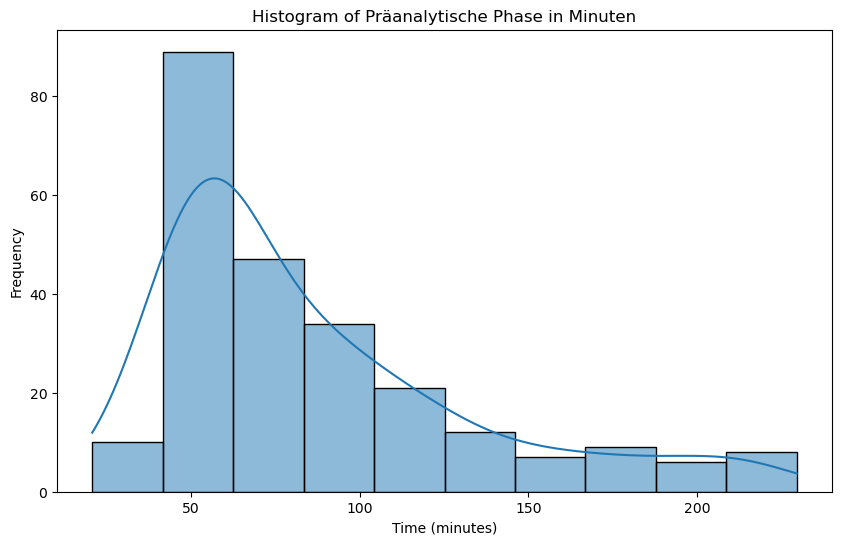

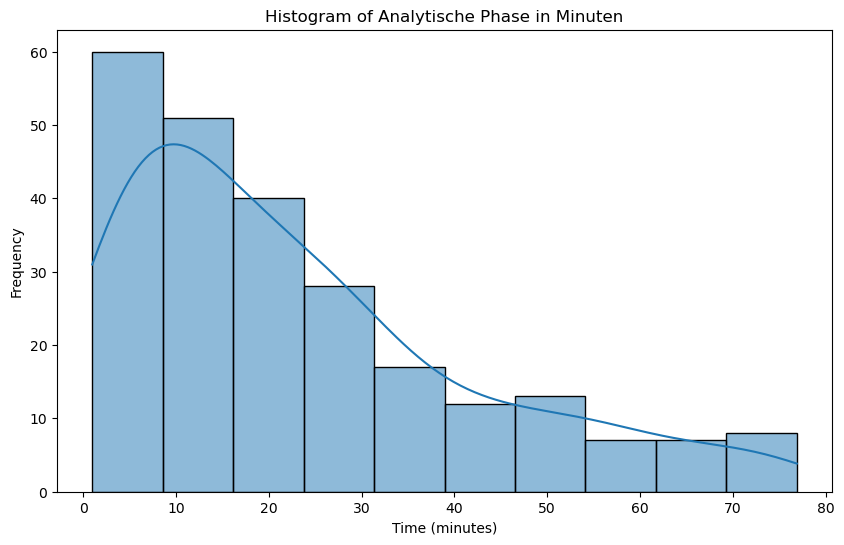

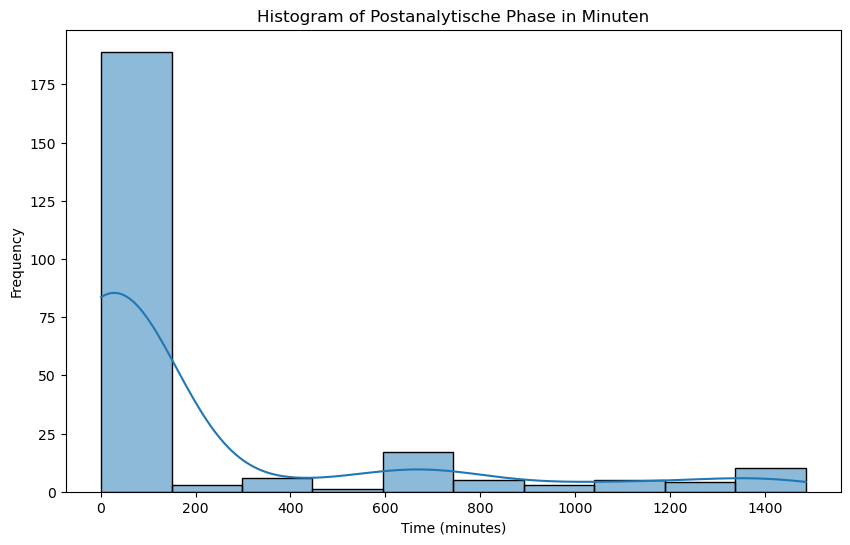

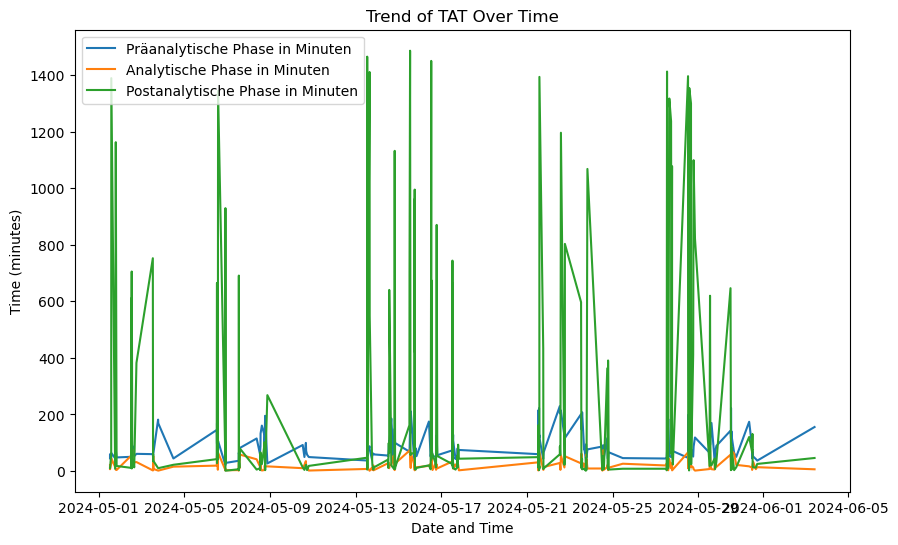

In [18]:
# Histogram for each phase without outliers
for phase in time_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_cleaned[phase], bins=10, kde=True)
    plt.title(f'Histogram of {phase}')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Frequency')
    plt.show()

# Line plot to show the trend of TAT over time
plt.figure(figsize=(10, 6))
for phase in time_columns:
    sns.lineplot(x=df_cleaned['Eingang'], y=df_cleaned[phase], label=phase)
plt.title('Trend of TAT Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Time (minutes)')
plt.legend()
plt.show()